In [41]:
import os
import pandas as pd
import numpy as np

# ---------- STEP 1: Load and Synchronise Empatica Signals (Corrected) ----------

def load_empatica(file_path, signal_name):
    """
    Loads a pre-processed Empatica CSV file where metadata is in columns,
    and creates a timestamped dataframe.
    """
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading CSV file {file_path}: {e}")
        return pd.DataFrame()

    # Handle IBI files, which use 'IBI_time' as an offset
    if 'IBI_time' in df.columns and 'start_time_unix' in df.columns:
        start_time_unix = df['start_time_unix'].iloc[0]
        # 'IBI_time' is the offset from the start time for each beat
        df['timestamp'] = pd.to_datetime(start_time_unix + df['IBI_time'], unit="s")
        df = df.drop(columns=['start_time_unix', 'IBI_time'])
        # Identify and rename the actual IBI value column (e.g., 'IBI_intervals')
        value_col = [c for c in df.columns if c not in ['timestamp']][0]
        df.rename(columns={value_col: 'value'}, inplace=True)
        df = df[['timestamp', 'value']]

    # Handle other signals with sampling rate
    elif 'start_time_unix' in df.columns and 'sampling_rate' in df.columns:
        start_time_unix = df['start_time_unix'].iloc[0]
        sampling_rate = df['sampling_rate'].iloc[0]
        
        if sampling_rate > 0:
            time_offset = np.arange(len(df)) / sampling_rate
            df['timestamp'] = pd.to_datetime(start_time_unix + time_offset, unit="s")
        else: # Handle case where sampling rate might be 0 or invalid
            df['timestamp'] = pd.to_datetime(start_time_unix, unit="s")
            
        df = df.drop(columns=['start_time_unix', 'sampling_rate'])
    
    else:
        print(f"⚠️ Could not find expected time columns in {file_path}")
        return pd.DataFrame()

    # Rename columns to be specific (e.g., "EDA_value", "ACC_x")
    df = df.rename(columns={c: f"{signal_name}_{c}" for c in df.columns if c != "timestamp"})
    return df


def synchronise_signals(folder, prefix="Left", resample_freq="1s"):
    """
    Loads all Empatica signals for a given prefix (Left/Right), merges them
    by timestamp, and resamples to a uniform frequency.
    """
    signals = ["ACC", "BVP", "EDA", "HR", "IBI", "TEMP"]
    dfs = []

    for sig in signals:
        file_path = os.path.join(folder, f"{prefix}_{sig}.csv")
        if not os.path.exists(file_path):
            print(f"⚠️ Missing {file_path}")
            continue
        
        df_sig = load_empatica(file_path, sig)
        if not df_sig.empty:
            dfs.append(df_sig.set_index('timestamp'))

    if not dfs:
        print(f"No data loaded for prefix {prefix}.")
        return pd.DataFrame()

    # Resample each dataframe before merging to handle different sampling rates
    resampled_dfs = [df.resample(resample_freq).mean() for df in dfs]

    # Concatenate along columns, filling NaNs from resampling
    merged = pd.concat(resampled_dfs, axis=1)
    merged = merged.ffill().bfill() # Forward and backward fill to handle gaps
    
    return merged.reset_index()

In [42]:
# ---------- STEP 2: Compute Cognitive Load Score (Feature-Derived) ----------

def get_experiment_start_time_from_csv(empatica_file):
    """Reads the Unix start time from the 'start_time_unix' column of an Empatica CSV."""
    try:
        df = pd.read_csv(empatica_file)
        if 'start_time_unix' in df.columns:
            return df['start_time_unix'].iloc[0]
        print(f"⚠️ 'start_time_unix' column not found in {empatica_file}")
        return None
    except Exception as e:
        print(f"Error reading start time from {empatica_file}: {e}")
        return None

def calculate_cognitive_load(nback_file, experiment_start_time, signals_df=None, method="feature_mix"):
    if experiment_start_time is None:
        raise ValueError("Invalid experiment start time provided.")
    
    df = pd.read_csv(nback_file)

    # --- Behavioral columns ---
    rt_cols = [col for col in df.columns if 'Stimulus' in col and col.endswith('.RT')]
    acc_cols = [col for col in df.columns if 'Stimulus' in col and col.endswith('.ACC')]
    onset_cols = [col for col in df.columns if 'Stimulus' in col and col.endswith('.OnsetTime')]

    df['RT'] = df[rt_cols].sum(axis=1, min_count=1)
    df['ACC'] = df[acc_cols].sum(axis=1, min_count=1)
    df['OnsetTime'] = df[onset_cols].sum(axis=1, min_count=1)
    df = df.dropna(subset=['RT','ACC','OnsetTime'])
    if df.empty:
        return pd.DataFrame(columns=['timestamp','Cognitive_Load'])

    df['timestamp'] = pd.to_datetime(experiment_start_time + df['OnsetTime']/1000, unit='s')

    # --- Feature-derived Cognitive_Load ---
    if method == "feature_mix" and signals_df is not None:
        # Rename physiological columns to standard names
        col_map = {
            'EDA_EDA': 'EDA',
            'HR_HR': 'HR',
            'TEMP_TEMP': 'TEMP',
            'BVP_BVP': 'BVP',
            'ACC_ACC_X': 'ACC_X',
            'ACC_ACC_Y': 'ACC_Y',
            'ACC_ACC_Z': 'ACC_Z'
        }
        signals_std = signals_df.rename(columns=col_map)

        # Compute accelerometer magnitude
        signals_std['ACC_MAG'] = (signals_std['ACC_X']**2 + signals_std['ACC_Y']**2 + signals_std['ACC_Z']**2)**0.5

        # Normalize features to [0,1]
        for f in ['EDA','HR','TEMP','BVP','ACC_MAG']:
            if f in signals_std:
                signals_std[f] = (signals_std[f] - signals_std[f].min()) / (signals_std[f].max() - signals_std[f].min() + 1e-6)

        # Merge with trial timestamps
        merged = pd.merge_asof(
            df.sort_values('timestamp'),
            signals_std.sort_values('timestamp'),
            on='timestamp',
            direction='backward',
            tolerance=pd.Timedelta('1s')
        )

        # Refined Cognitive_Load formula with interactions and stronger weights
        merged['Cognitive_Load'] = (
            0.35 * merged['ACC'] +
            0.25 * (1 - merged['RT'] / (merged['RT'].max() + 1e-6)) +
            0.15 * merged['EDA'] +
            0.10 * merged['HR'] +
            0.10 * merged['TEMP'] +
            0.05 * merged['ACC_MAG'] +
            0.10 * (merged['HR'] * merged['EDA']) +
            0.05 * (merged['BVP'] * merged['TEMP'])
        )

        df = merged[['timestamp','Cognitive_Load']]

    else:
        # fallback
        positive_rts = df.loc[df['RT']>0,'RT']
        rt_max = np.nanpercentile(positive_rts,95) if not positive_rts.empty else None
        df['Cognitive_Load'] = df['ACC'] * (1 - (df['RT']/(rt_max+1e-6)))
        df = df[['timestamp','Cognitive_Load']]

    df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)
    return df


In [43]:
import os
import pandas as pd

all_data = []  # collect all participant data here

# Define participant groups
experiments = {
    "Experiment_1": [f"A{i}" for i in range(1, 11)],
    "Experiment_2": [f"B{i}" for i in range(1, 11)]
}

for exp_name, participants in experiments.items():
    for participant in participants:
        participant_folder = os.path.join(exp_name, participant)
        print(f"\n🔄 Processing data for participant: {participant_folder}")

        # Synchronise signals
        left_synced = synchronise_signals(participant_folder, prefix="Left", resample_freq="1s")
        right_synced = synchronise_signals(participant_folder, prefix="Right", resample_freq="1s")

        # Load experiment start time
        start_time_file = os.path.join(participant_folder, "Left_EDA.csv")
        exp_start_time = get_experiment_start_time_from_csv(start_time_file)

        # Load N-Back response file
        nback_file = os.path.join(participant_folder, "n_back_responses.csv")

        if exp_start_time and not left_synced.empty:
            # ✅ Pass in signals_df explicitly (so cognitive load is derived from features!)
            cognitive_scores = calculate_cognitive_load(nback_file, exp_start_time, left_synced)
            print("✅ Cognitive scores calculated successfully (feature-derived proxy).")

            # Merge Left
            left_final = pd.merge_asof(
                left_synced.sort_values("timestamp"),
                cognitive_scores.sort_values("timestamp"),
                on="timestamp",
                direction="backward",
                tolerance=pd.Timedelta('2s')
            )
            left_final['Cognitive_Load'] = left_final['Cognitive_Load'].ffill()

            # Merge Right (re-use cognitive_scores, still aligned by timestamp)
            right_final = pd.merge_asof(
                right_synced.sort_values("timestamp"),
                cognitive_scores.sort_values("timestamp"),
                on="timestamp",
                direction="backward",
                tolerance=pd.Timedelta('2s')
            )
            right_final['Cognitive_Load'] = right_final['Cognitive_Load'].ffill()

            # Add participant + experiment identifiers
            left_final["Participant"] = participant
            left_final["Experiment"] = exp_name
            left_final["Hand"] = "Left"

            right_final["Participant"] = participant
            right_final["Experiment"] = exp_name
            right_final["Hand"] = "Right"

            # Combine left and right into one participant dataframe
            combined = pd.concat([left_final, right_final], ignore_index=True)

            # Append to global list
            all_data.append(combined)

            print(f"✅ Merging complete for {participant_folder}. Shape:", combined.shape)

        else:
            print(f"❌ Skipping {participant_folder}: Missing start time or signals.")

# Concatenate all participants’ data
if all_data:
    final_dataset = pd.concat(all_data, ignore_index=True)
    print("\n🎉 Final dataset shape:", final_dataset.shape)

    # Save to one file
    output_folder = "output"
    os.makedirs(output_folder, exist_ok=True)
    final_dataset.to_csv(os.path.join(output_folder, "all_participants_final.csv"), index=False)
    print(f"✅ Final dataset saved to '{output_folder}/all_participants_final.csv'")
else:
    print("❌ No data processed.")



🔄 Processing data for participant: Experiment_1\A1


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_1\A1. Shape: (9806, 13)

🔄 Processing data for participant: Experiment_1\A2


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_1\A2. Shape: (10942, 13)

🔄 Processing data for participant: Experiment_1\A3


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_1\A3. Shape: (10396, 13)

🔄 Processing data for participant: Experiment_1\A4


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_1\A4. Shape: (10684, 13)

🔄 Processing data for participant: Experiment_1\A5


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_1\A5. Shape: (9940, 13)

🔄 Processing data for participant: Experiment_1\A6


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_1\A6. Shape: (10468, 13)

🔄 Processing data for participant: Experiment_1\A7


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_1\A7. Shape: (10608, 13)

🔄 Processing data for participant: Experiment_1\A8


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_1\A8. Shape: (10020, 13)

🔄 Processing data for participant: Experiment_1\A9


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_1\A9. Shape: (10019, 13)

🔄 Processing data for participant: Experiment_1\A10


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_1\A10. Shape: (10134, 13)

🔄 Processing data for participant: Experiment_2\B1


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_2\B1. Shape: (11180, 13)

🔄 Processing data for participant: Experiment_2\B2


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_2\B2. Shape: (11504, 13)

🔄 Processing data for participant: Experiment_2\B3


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_2\B3. Shape: (11420, 13)

🔄 Processing data for participant: Experiment_2\B4


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_2\B4. Shape: (11656, 13)

🔄 Processing data for participant: Experiment_2\B5


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_2\B5. Shape: (11904, 13)

🔄 Processing data for participant: Experiment_2\B6


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_2\B6. Shape: (11328, 13)

🔄 Processing data for participant: Experiment_2\B7


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_2\B7. Shape: (11368, 13)

🔄 Processing data for participant: Experiment_2\B8


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_2\B8. Shape: (11536, 13)

🔄 Processing data for participant: Experiment_2\B9


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_2\B9. Shape: (12708, 13)

🔄 Processing data for participant: Experiment_2\B10


C:\Users\chand\AppData\Local\Temp\ipykernel_27768\1949193118.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cognitive_Load'] = df['Cognitive_Load'].clip(lower=0)


✅ Cognitive scores calculated successfully (feature-derived proxy).
✅ Merging complete for Experiment_2\B10. Shape: (11688, 13)

🎉 Final dataset shape: (219309, 13)
✅ Final dataset saved to 'output/all_participants_final.csv'


In [44]:
final_dataset['Cognitive_Load'].describe()

count    210651.000000
mean          0.499190
std           0.101823
min           0.096823
25%           0.424148
50%           0.486304
75%           0.574361
max           0.872330
Name: Cognitive_Load, dtype: float64

In [45]:
final_dataset.isnull().sum()

timestamp            0
ACC_ACC_X            0
ACC_ACC_Y            0
ACC_ACC_Z            0
BVP_BVP              0
EDA_EDA              0
HR_HR                0
IBI_value            0
TEMP_TEMP            0
Cognitive_Load    8658
Participant          0
Experiment           0
Hand                 0
dtype: int64

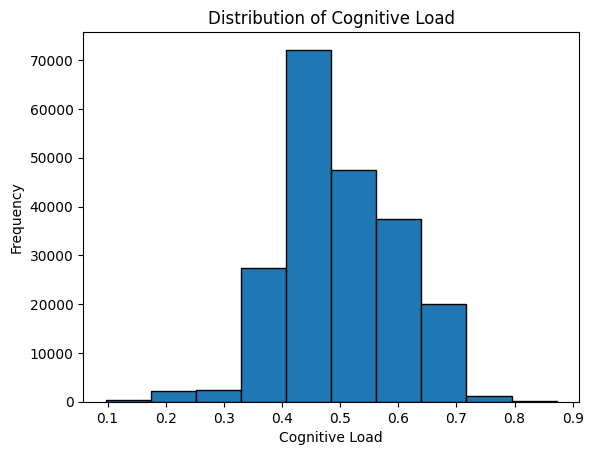

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# This part of the code plots the histogram
plt.hist(final_dataset['Cognitive_Load'], bins=10, edgecolor='black')

# These lines add a title and labels to your plot
plt.title('Distribution of Cognitive Load')
plt.xlabel('Cognitive Load')
plt.ylabel('Frequency')

# Finally, this line saves the plot as an image file
plt.savefig('cognitive_load_distribution.png')

X shape: (7020, 60, 8)
y shape: (7020,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 60, 64)            2624      
                                                                 
 batch_normalization_10 (Ba  (None, 60, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 30, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 30, 128)           41088     
                                                                 
 batch_normali

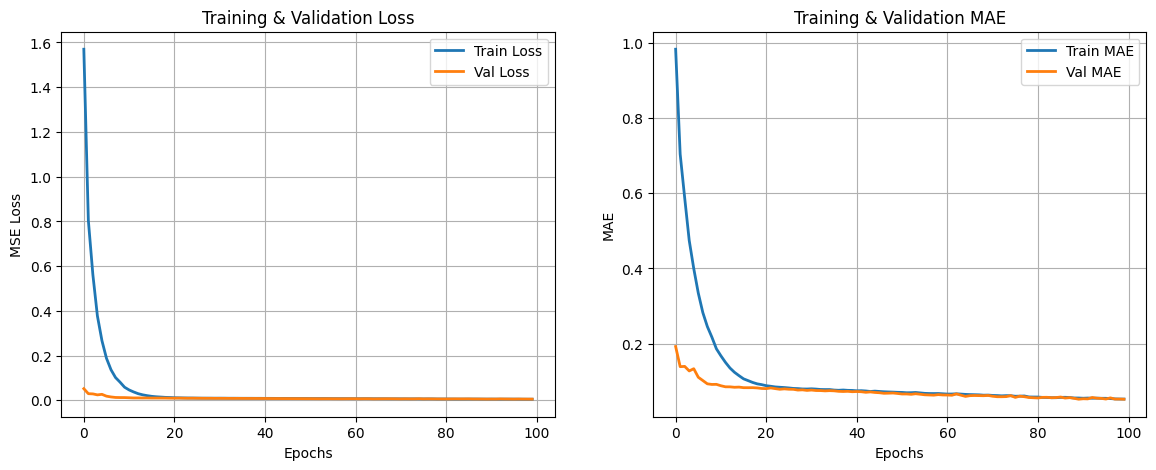

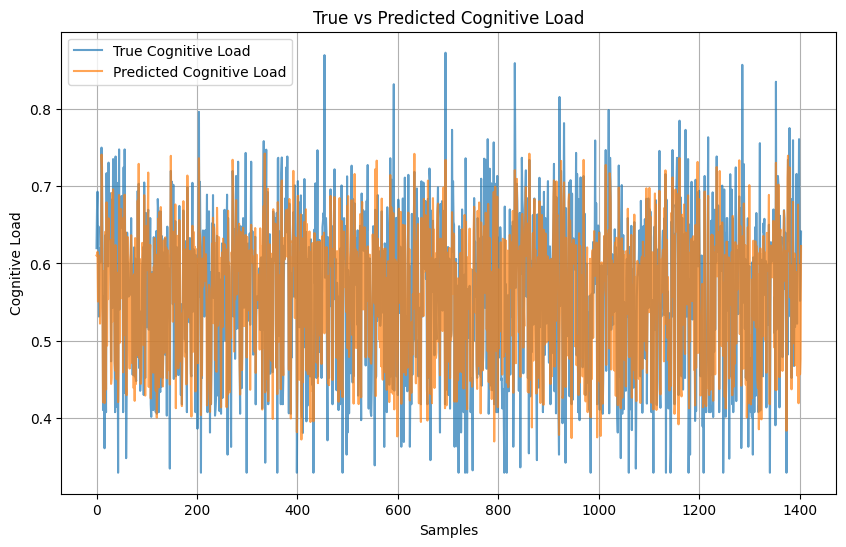

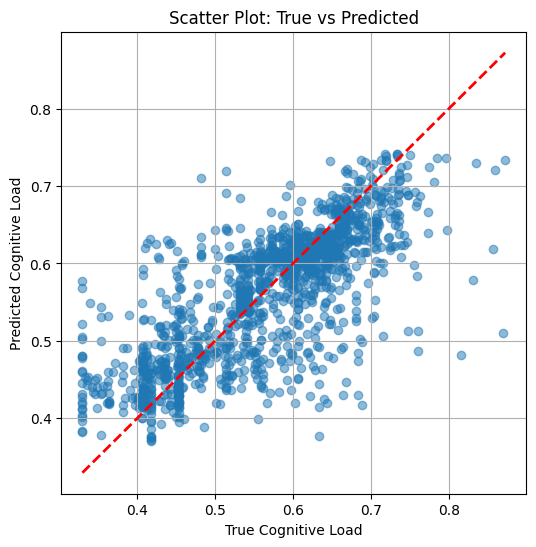

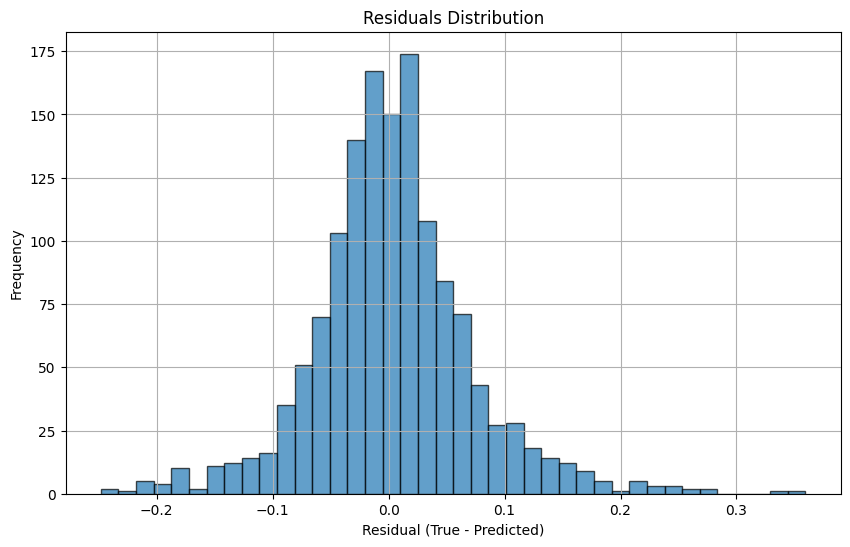

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------- STEP 1: Preprocess ---------------- #
final_dataset = final_dataset.dropna(subset=["Cognitive_Load"]).reset_index(drop=True)

feature_cols = [
    "ACC_ACC_X", "ACC_ACC_Y", "ACC_ACC_Z",
    "BVP_BVP", "EDA_EDA", "HR_HR",
    "IBI_value", "TEMP_TEMP"
]

# Normalize features
scaler = StandardScaler()
final_dataset[feature_cols] = scaler.fit_transform(final_dataset[feature_cols])

# ---------------- STEP 2: Create sliding windows ---------------- #
def create_windows(df, feature_cols, window_size=60, stride=30):
    X, y = [], []
    data = df[feature_cols].values
    labels = df["Cognitive_Load"].values

    for start in range(0, len(df) - window_size + 1, stride):
        end = start + window_size
        X_window = data[start:end]
        y_window = labels[start:end]

        X.append(X_window)
        y.append(np.max(y_window))  # max Cognitive_Load

    return np.array(X), np.array(y)

X, y = create_windows(final_dataset, feature_cols)

print("X shape:", X.shape)  # (num_windows, 60, num_features)
print("y shape:", y.shape)

# ---------------- STEP 3: Train-test split ---------------- #
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------- STEP 4: Define Model ---------------- #
def create_stress_cnn_lstm_model(input_shape):
    """
    Hybrid CNN + LSTM model for stress/cognitive load prediction.
    """
    model = Sequential([
        # First convolutional block
        Conv1D(64, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Second convolutional block
        Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Third convolutional block
        Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # LSTMs
        LSTM(128, return_sequences=True),
        Dropout(0.4),
        LSTM(64, return_sequences=False),
        Dropout(0.3),

        # Dense layers
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = create_stress_cnn_lstm_model(input_shape)
model.summary()

# ---------------- STEP 5: Callbacks ---------------- #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_stress_cnn_lstm_model_v2.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

# ---------------- STEP 6: Train ---------------- #
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, lr_reducer],
    verbose=1
)

# ---------------- STEP 7: Evaluate ---------------- #
y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# ---------------- STEP 8: Plots ---------------- #
# 1. Training history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel("Epochs"); plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
plt.xlabel("Epochs"); plt.ylabel("MAE")
plt.title("Training & Validation MAE")
plt.legend(); plt.grid(True)
plt.show()

# 2. Predictions vs True
plt.figure(figsize=(10,6))
plt.plot(y_test, label="True Cognitive Load", alpha=0.7)
plt.plot(y_pred, label="Predicted Cognitive Load", alpha=0.7)
plt.title("True vs Predicted Cognitive Load")
plt.xlabel("Samples")
plt.ylabel("Cognitive Load")
plt.legend(); plt.grid(True)
plt.show()

# 3. Scatter Plot (Goodness of Fit)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True Cognitive Load")
plt.ylabel("Predicted Cognitive Load")
plt.title("Scatter Plot: True vs Predicted")
plt.grid(True)
plt.show()

# 4. Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=40, edgecolor='black', alpha=0.7)
plt.title("Residuals Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
